# Method 8 - Rest Ideas After 1

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Use Raw Weight

valid_data['adj_target'] = valid_data['target']

## Calculate Rest Ideas

In [3]:
# Extract Rest Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] > 1].copy()

# Weight the best ideas

best_ideas['target'] = best_ideas['target'] / best_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / best_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

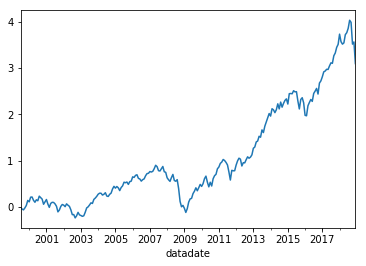

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.141621
2000-12-31   -0.029822
2001-12-31   -0.048885
2002-12-31   -0.212756
2003-12-31    0.482063
2004-12-31    0.176191
2005-12-31    0.076837
2006-12-31    0.109310
2007-12-31    0.012182
2008-12-31   -0.408274
2009-12-31    0.438021
2010-12-31    0.226419
2011-12-31   -0.022932
2012-12-31    0.192469
2013-12-31    0.419322
2014-12-31    0.104953
2015-12-31   -0.025302
2016-12-31    0.145336
2017-12-31    0.211723
2018-12-31   -0.092000
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     2875.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.11e-194
Time:                        07:13:04   Log-Likelihood:                 832.05
No. Observations:                 234   AIC:                            -1654.
Df Residuals:                     229   BIC:                            -1637.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      4.657      0.000       0.001       0.003
mktrf          1.0146      0.013     77.877      0.000       0.989       1.040
me             0.2955      0.015     19.500      0.000       0.266       0.325
ia             0.0589      0.023      2.559      0.011       0.014       0.104
roe           -0.0725      0.020     -3.677      0.000      -0.111      -0.034
==============================================================================
Omnibus:                       27.073   Durbin-Watson:                   1.868
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              140.850
Skew:                          -0.087   Prob(JB):                     2.60e-31
Kurtosis:                       6.797   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     1650.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.60e-167
Time:                        07:13:05   Log-Likelihood:                 832.05
No. Observations:                 234   AIC:                            -1654.
Df Residuals:                     229   BIC:                            -1637.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      4.588      0.000       0.001       0.003
mktrf          1.0146      0.016     63.920      0.000       0.984       1.046
me             0.2955      0.023     12.940      0.000       0.251       0.340
ia             0.0589      0.046      1.295      0.195      -0.030       0.148
roe           -0.0725      0.029     -2.533      0.011      -0.129      -0.016
==============================================================================
Omnibus:                       27.073   Durbin-Watson:                   1.868
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              140.850
Skew:                          -0.087   Prob(JB):                     2.60e-31
Kurtosis:                       6.797   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     2025.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.20e-177
Time:                        07:13:05   Log-Likelihood:                 832.05
No. Observations:                 234   AIC:                            -1654.
Df Residuals:                     229   BIC:                            -1637.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      4.858      0.000       0.001       0.003
mktrf          1.0146      0.015     66.624      0.000       0.985       1.044
me             0.2955      0.022     13.424      0.000       0.252       0.339
ia             0.0589      0.047      1.249      0.212      -0.034       0.151
roe           -0.0725      0.032     -2.279      0.023      -0.135      -0.010
==============================================================================
Omnibus:                       27.073   Durbin-Watson:                   1.868
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              140.850
Skew:                          -0.087   Prob(JB):                     2.60e-31
Kurtosis:                       6.797   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1905.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          9.64e-184
Time:                        07:13:05   Log-Likelihood:                 811.01
No. Observations:                 234   AIC:                            -1610.
Df Residuals:                     228   BIC:                            -1589.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.616      0.000       0.001       0.003
mktrf          1.0328      0.014     72.152      0.000       1.005       1.061
smb            0.3226      0.019     17.080      0.000       0.285       0.360
hml            0.0207      0.022      0.930      0.353      -0.023       0.065
rmw           -0.0446      0.025     -1.771      0.078      -0.094       0.005
cma            0.0581      0.032      1.814      0.071      -0.005       0.121
==============================================================================
Omnibus:                       27.637   Durbin-Watson:                   1.714
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              147.506
Skew:                           0.090   Prob(JB):                     9.32e-33
Kurtosis:                       6.885   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1515.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.06e-172
Time:                        07:13:05   Log-Likelihood:                 811.01
No. Observations:                 234   AIC:                            -1610.
Df Residuals:                     228   BIC:                            -1589.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.405      0.001       0.001       0.003
mktrf          1.0328      0.018     58.334      0.000       0.998       1.067
smb            0.3226      0.024     13.448      0.000       0.276       0.370
hml            0.0207      0.049      0.419      0.676      -0.076       0.118
rmw           -0.0446      0.031     -1.416      0.157      -0.106       0.017
cma            0.0581      0.049      1.173      0.241      -0.039       0.155
==============================================================================
Omnibus:                       27.637   Durbin-Watson:                   1.714
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              147.506
Skew:                           0.090   Prob(JB):                     9.32e-33
Kurtosis:                       6.885   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     2045.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.68e-187
Time:                        07:13:05   Log-Likelihood:                 811.01
No. Observations:                 234   AIC:                            -1610.
Df Residuals:                     228   BIC:                            -1589.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.372      0.001       0.001       0.003
mktrf          1.0328      0.017     60.710      0.000       0.999       1.066
smb            0.3226      0.024     13.422      0.000       0.275       0.370
hml            0.0207      0.052      0.401      0.688      -0.080       0.122
rmw           -0.0446      0.035     -1.288      0.198      -0.112       0.023
cma            0.0581      0.048      1.209      0.227      -0.036       0.152
==============================================================================
Omnibus:                       27.637   Durbin-Watson:                   1.714
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              147.506
Skew:                           0.090   Prob(JB):                     9.32e-33
Kurtosis:                       6.885   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     2141.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.46e-180
Time:                        07:13:05   Log-Likelihood:                 798.34
No. Observations:                 234   AIC:                            -1587.
Df Residuals:                     229   BIC:                            -1569.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      3.754      0.000       0.001       0.003
mktrf          1.0279      0.014     74.191      0.000       1.001       1.055
smb            0.3277      0.017     18.948      0.000       0.294       0.362
hml            0.0883      0.017      5.142      0.000       0.054       0.122
umd           -0.0235      0.011     -2.083      0.038      -0.046      -0.001
==============================================================================
Omnibus:                       26.630   Durbin-Watson:                   1.789
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              132.890
Skew:                           0.116   Prob(JB):                     1.39e-29
Kurtosis:                       6.684   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     1767.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          8.35e-171
Time:                        07:13:05   Log-Likelihood:                 798.34
No. Observations:                 234   AIC:                            -1587.
Df Residuals:                     229   BIC:                            -1569.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      3.154      0.002       0.001       0.003
mktrf          1.0279      0.019     54.524      0.000       0.991       1.065
smb            0.3277      0.023     14.371      0.000       0.283       0.372
hml            0.0883      0.049      1.804      0.071      -0.008       0.184
umd           -0.0235      0.021     -1.114      0.265      -0.065       0.018
==============================================================================
Omnibus:                       26.630   Durbin-Watson:                   1.789
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              132.890
Skew:                           0.116   Prob(JB):                     1.39e-29
Kurtosis:                       6.684   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     2199.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.20e-181
Time:                        07:13:05   Log-Likelihood:                 798.34
No. Observations:                 234   AIC:                            -1587.
Df Residuals:                     229   BIC:                            -1569.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      3.126      0.002       0.001       0.003
mktrf          1.0279      0.016     63.766      0.000       0.996       1.059
smb            0.3277      0.024     13.800      0.000       0.281       0.374
hml            0.0883      0.054      1.634      0.102      -0.018       0.194
umd           -0.0235      0.017     -1.366      0.172      -0.057       0.010
==============================================================================
Omnibus:                       26.630   Durbin-Watson:                   1.789
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              132.890
Skew:                           0.116   Prob(JB):                     1.39e-29
Kurtosis:                       6.684   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1267.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.64e-94
Time:                        07:13:05   Log-Likelihood:                 406.61
No. Observations:                 120   AIC:                            -803.2
Df Residuals:                     115   BIC:                            -789.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      3.669      0.000       0.001       0.005
mktrf          1.0192      0.022     47.381      0.000       0.977       1.062
me             0.2764      0.021     13.008      0.000       0.234       0.318
ia             0.0958      0.033      2.878      0.005       0.030       0.162
roe           -0.0726      0.029     -2.466      0.015      -0.131      -0.014
==============================================================================
Omnibus:                       10.815   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               27.203
Skew:                          -0.116   Prob(JB):                     1.24e-06
Kurtosis:                       5.321   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     918.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.98e-86
Time:                        07:13:05   Log-Likelihood:                 406.61
No. Observations:                 120   AIC:                            -803.2
Df Residuals:                     115   BIC:                            -789.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      3.653      0.000       0.001       0.004
mktrf          1.0192      0.027     37.585      0.000       0.966       1.072
me             0.2764      0.024     11.460      0.000       0.229       0.324
ia             0.0958      0.051      1.881      0.060      -0.004       0.196
roe           -0.0726      0.035     -2.050      0.040      -0.142      -0.003
==============================================================================
Omnibus:                       10.815   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               27.203
Skew:                          -0.116   Prob(JB):                     1.24e-06
Kurtosis:                       5.321   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1456.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.84e-97
Time:                        07:13:05   Log-Likelihood:                 406.61
No. Observations:                 120   AIC:                            -803.2
Df Residuals:                     115   BIC:                            -789.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      3.764      0.000       0.001       0.004
mktrf          1.0192      0.023     43.430      0.000       0.973       1.065
me             0.2764      0.024     11.512      0.000       0.229       0.323
ia             0.0958      0.047      2.059      0.040       0.005       0.187
roe           -0.0726      0.037     -1.948      0.051      -0.146       0.000
==============================================================================
Omnibus:                       10.815   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               27.203
Skew:                          -0.116   Prob(JB):                     1.24e-06
Kurtosis:                       5.321   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     819.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.40e-87
Time:                        07:13:05   Log-Likelihood:                 394.72
No. Observations:                 120   AIC:                            -777.4
Df Residuals:                     114   BIC:                            -760.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      3.452      0.001       0.001       0.005
mktrf          1.0706      0.025     42.562      0.000       1.021       1.120
smb            0.3200      0.028     11.231      0.000       0.264       0.376
hml           -0.0056      0.035     -0.161      0.872      -0.075       0.064
rmw           -0.0095      0.041     -0.232      0.817      -0.091       0.072
cma            0.1234      0.045      2.736      0.007       0.034       0.213
==============================================================================
Omnibus:                       12.234   Durbin-Watson:                   1.834
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               34.984
Skew:                          -0.114   Prob(JB):                     2.53e-08
Kurtosis:                       5.635   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     941.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.51e-91
Time:                        07:13:05   Log-Likelihood:                 394.72
No. Observations:                 120   AIC:                            -777.4
Df Residuals:                     114   BIC:                            -760.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      3.433      0.001       0.001       0.005
mktrf          1.0706      0.035     30.987      0.000       1.003       1.138
smb            0.3200      0.037      8.680      0.000       0.248       0.392
hml           -0.0056      0.081     -0.069      0.945      -0.165       0.154
rmw           -0.0095      0.064     -0.150      0.881      -0.134       0.115
cma            0.1234      0.060      2.059      0.039       0.006       0.241
==============================================================================
Omnibus:                       12.234   Durbin-Watson:                   1.834
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               34.984
Skew:                          -0.114   Prob(JB):                     2.53e-08
Kurtosis:                       5.635   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     1633.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.72e-104
Time:                        07:13:05   Log-Likelihood:                 394.72
No. Observations:                 120   AIC:                            -777.4
Df Residuals:                     114   BIC:                            -760.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      3.600      0.000       0.001       0.005
mktrf          1.0706      0.033     32.288      0.000       1.006       1.136
smb            0.3200      0.038      8.457      0.000       0.246       0.394
hml           -0.0056      0.087     -0.065      0.948      -0.176       0.164
rmw           -0.0095      0.070     -0.136      0.892      -0.147       0.128
cma            0.1234      0.058      2.142      0.032       0.010       0.236
==============================================================================
Omnibus:                       12.234   Durbin-Watson:                   1.834
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               34.984
Skew:                          -0.114   Prob(JB):                     2.53e-08
Kurtosis:                       5.635   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     887.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.01e-85
Time:                        07:13:05   Log-Likelihood:                 385.85
No. Observations:                 120   AIC:                            -761.7
Df Residuals:                     115   BIC:                            -747.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      3.770      0.000       0.002       0.005
mktrf          1.0416      0.023     46.233      0.000       0.997       1.086
smb            0.3193      0.026     12.448      0.000       0.268       0.370
hml            0.1062      0.026      4.134      0.000       0.055       0.157
umd           -0.0202      0.016     -1.275      0.205      -0.052       0.011
==============================================================================
Omnibus:                       11.768   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               33.239
Skew:                          -0.063   Prob(JB):                     6.06e-08
Kurtosis:                       5.575   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     1069.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.40e-90
Time:                        07:13:05   Log-Likelihood:                 385.85
No. Observations:                 120   AIC:                            -761.7
Df Residuals:                     115   BIC:                            -747.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      3.941      0.000       0.002       0.005
mktrf          1.0416      0.030     34.206      0.000       0.982       1.101
smb            0.3193      0.028     11.265      0.000       0.264       0.375
hml            0.1062      0.062      1.700      0.089      -0.016       0.229
umd           -0.0202      0.025     -0.799      0.424      -0.070       0.029
==============================================================================
Omnibus:                       11.768   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               33.239
Skew:                          -0.063   Prob(JB):                     6.06e-08
Kurtosis:                       5.575   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     1496.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.93e-98
Time:                        07:13:05   Log-Likelihood:                 385.85
No. Observations:                 120   AIC:                            -761.7
Df Residuals:                     115   BIC:                            -747.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      4.220      0.000       0.002       0.005
mktrf          1.0416      0.024     43.691      0.000       0.995       1.088
smb            0.3193      0.030     10.780      0.000       0.261       0.377
hml            0.1062      0.068      1.570      0.116      -0.026       0.239
umd           -0.0202      0.020     -1.025      0.305      -0.059       0.018
==============================================================================
Omnibus:                       11.768   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               33.239
Skew:                          -0.063   Prob(JB):                     6.06e-08
Kurtosis:                       5.575   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     2492.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.92e-106
Time:                        07:13:05   Log-Likelihood:                 456.05
No. Observations:                 114   AIC:                            -902.1
Df Residuals:                     109   BIC:                            -888.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.000      3.690      0.000       0.001       0.003
mktrf          1.0108      0.013     75.889      0.000       0.984       1.037
me             0.3362      0.021     16.350      0.000       0.295       0.377
ia            -0.0705      0.029     -2.472      0.015      -0.127      -0.014
roe           -0.1252      0.025     -4.994      0.000      -0.175      -0.075
==============================================================================
Omnibus:                        9.184   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                9.004
Skew:                          -0.637   Prob(JB):                       0.0111
Kurtosis:                       3.521   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     3839.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.89e-116
Time:                        07:13:05   Log-Likelihood:                 456.05
No. Observations:                 114   AIC:                            -902.1
Df Residuals:                     109   BIC:                            -888.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.000      3.939      0.000       0.001       0.002
mktrf          1.0108      0.010     96.370      0.000       0.990       1.031
me             0.3362      0.016     20.673      0.000       0.304       0.368
ia            -0.0705      0.030     -2.326      0.020      -0.130      -0.011
roe           -0.1252      0.024     -5.168      0.000      -0.173      -0.078
==============================================================================
Omnibus:                        9.184   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                9.004
Skew:                          -0.637   Prob(JB):                       0.0111
Kurtosis:                       3.521   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     4340.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.79e-119
Time:                        07:13:06   Log-Likelihood:                 456.05
No. Observations:                 114   AIC:                            -902.1
Df Residuals:                     109   BIC:                            -888.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.000      3.803      0.000       0.001       0.003
mktrf          1.0108      0.010    100.559      0.000       0.991       1.031
me             0.3362      0.016     20.755      0.000       0.304       0.368
ia            -0.0705      0.033     -2.133      0.033      -0.135      -0.006
roe           -0.1252      0.023     -5.509      0.000      -0.170      -0.081
==============================================================================
Omnibus:                        9.184   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                9.004
Skew:                          -0.637   Prob(JB):                       0.0111
Kurtosis:                       3.521   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     2518.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.86e-110
Time:                        07:13:06   Log-Likelihood:                 469.74
No. Observations:                 114   AIC:                            -927.5
Df Residuals:                     108   BIC:                            -911.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      1.898      0.060    -3.4e-05       0.002
mktrf          1.0178      0.011     89.938      0.000       0.995       1.040
smb            0.3113      0.018     16.943      0.000       0.275       0.348
hml            0.0144      0.023      0.614      0.540      -0.032       0.061
rmw           -0.1847      0.029     -6.437      0.000      -0.242      -0.128
cma           -0.0910      0.036     -2.497      0.014      -0.163      -0.019
==============================================================================
Omnibus:                       10.221   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.248
Skew:                          -0.685   Prob(JB):                      0.00595
Kurtosis:                       3.532   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     2705.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.05e-111
Time:                        07:13:06   Log-Likelihood:                 469.74
No. Observations:                 114   AIC:                            -927.5
Df Residuals:                     108   BIC:                            -911.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      1.853      0.064   -4.41e-05       0.002
mktrf          1.0178      0.010    106.419      0.000       0.999       1.037
smb            0.3113      0.016     19.356      0.000       0.280       0.343
hml            0.0144      0.019      0.759      0.448      -0.023       0.052
rmw           -0.1847      0.026     -7.073      0.000      -0.236      -0.134
cma           -0.0910      0.039     -2.305      0.021      -0.168      -0.014
==============================================================================
Omnibus:                       10.221   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.248
Skew:                          -0.685   Prob(JB):                      0.00595
Kurtosis:                       3.532   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     4326.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.21e-122
Time:                        07:13:06   Log-Likelihood:                 469.74
No. Observations:                 114   AIC:                            -927.5
Df Residuals:                     108   BIC:                            -911.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      1.706      0.088      -0.000       0.002
mktrf          1.0178      0.008    126.224      0.000       1.002       1.034
smb            0.3113      0.015     20.558      0.000       0.282       0.341
hml            0.0144      0.018      0.798      0.425      -0.021       0.050
rmw           -0.1847      0.027     -6.799      0.000      -0.238      -0.131
cma           -0.0910      0.041     -2.241      0.025      -0.171      -0.011
==============================================================================
Omnibus:                       10.221   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.248
Skew:                          -0.685   Prob(JB):                      0.00595
Kurtosis:                       3.532   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     2149.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.14e-102
Time:                        07:13:06   Log-Likelihood:                 447.70
No. Observations:                 114   AIC:                            -885.4
Df Residuals:                     109   BIC:                            -871.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      0.791      0.431      -0.001       0.001
mktrf          1.0306      0.014     75.890      0.000       1.004       1.058
smb            0.3538      0.021     16.708      0.000       0.312       0.396
hml            0.0099      0.022      0.453      0.652      -0.033       0.053
umd           -0.0379      0.016     -2.305      0.023      -0.071      -0.005
==============================================================================
Omnibus:                        4.233   Durbin-Watson:                   1.738
Prob(Omnibus):                  0.120   Jarque-Bera (JB):                3.615
Skew:                          -0.396   Prob(JB):                        0.164
Kurtosis:                       3.367   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     1732.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.26e-97
Time:                        07:13:06   Log-Likelihood:                 447.70
No. Observations:                 114   AIC:                            -885.4
Df Residuals:                     109   BIC:                            -871.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.758      0.449      -0.001       0.001
mktrf          1.0306      0.014     74.474      0.000       1.004       1.058
smb            0.3538      0.019     18.841      0.000       0.317       0.391
hml            0.0099      0.020      0.490      0.624      -0.030       0.049
umd           -0.0379      0.012     -3.056      0.002      -0.062      -0.014
==============================================================================
Omnibus:                        4.233   Durbin-Watson:                   1.738
Prob(Omnibus):                  0.120   Jarque-Bera (JB):                3.615
Skew:                          -0.396   Prob(JB):                        0.164
Kurtosis:                       3.367   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     3209.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.69e-112
Time:                        07:13:06   Log-Likelihood:                 447.70
No. Observations:                 114   AIC:                            -885.4
Df Residuals:                     109   BIC:                            -871.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.758      0.448      -0.001       0.001
mktrf          1.0306      0.013     80.165      0.000       1.005       1.056
smb            0.3538      0.014     24.836      0.000       0.326       0.382
hml            0.0099      0.017      0.589      0.556      -0.023       0.043
umd           -0.0379      0.012     -3.195      0.001      -0.061      -0.015
==============================================================================
Omnibus:                        4.233   Durbin-Watson:                   1.738
Prob(Omnibus):                  0.120   Jarque-Bera (JB):                3.615
Skew:                          -0.396   Prob(JB):                        0.164
Kurtosis:                       3.367   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""